In [1]:
import pickle
import numpy as np

import matplotlib.pyplot as plt

from visTools_v2.core_functions.operations.get_patches import get_patches

In [2]:
from PIL import Image

def load_img(im1):
    im1 = Image.open(im1)
    im1 = np.array(im1)
    im1 = np.moveaxis(im1,2,0)[np.newaxis,:,:,:]
    return im1

In [3]:
def rgb_to_hsv(r, g, b):
    r, g, b = r/255.0, g/255.0, b/255.0
    mx = max(r, g, b)
    mn = min(r, g, b)
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60 * ((g-b)/df) + 360) % 360
    elif mx == g:
        h = (60 * ((b-r)/df) + 120) % 360
    elif mx == b:
        h = (60 * ((r-g)/df) + 240) % 360
    if mx == 0:
        s = 0
    else:
        s = (df/mx)*100
    v = mx*100
    return h, s, v


In [4]:
def RGBB2HSV(im1):

    im1 = np.squeeze(im1)
    C,H,W = im1.shape
    im1 = im1.reshape((C,H*W))
    
    for i in range(im1.shape[1]):
        r,g,b= im1[:,i]
        im1[:,i] = rgb_to_hsv(r, g, b)
        
    im1 = im1.reshape((C,H,W))
    
    return im1[np.newaxis,:2,:,:]


# Initialization

In [5]:
def init(X,k,method='random_selection'):
    if method=='random_selection':
        idx = np.arange(X.shape[0])
        idx = np.random.permutation(idx)
        cs = X[np.random.choice(idx,k),:]
    if method=='random_clustering':
        idx = np.random.randint(0,k,X.shape[0])
        cs = []
        for i in range(k):
            cluster_id = np.argwhere(idx==i)
            cs.append(np.mean(X[cluster_id,:],axis=0))
        cs = np.squeeze(np.array(cs))
    if method=='k++':
        idx = np.arange(X.shape[0])
        cs = []
        cs.append(X[np.random.choice(idx),:])
        for kk in range(k-1):
            d = dists(X,np.array(cs))
            d = np.min(d**2,axis=1)
            id0 = np.random.choice(idx,p=d/np.sum(d))
            cs.append(X[id0,:])
        cs = np.array(cs)
        
    return cs

# Distance to cluster centers

In [6]:
def dists(X,cs,im_shape=(None,None),include_coords=True):
    dists = (X[:,:,np.newaxis] - cs.T[np.newaxis,:,:])**2
    dists = np.sqrt(np.sum(dists,axis=1)    )
    return dists

def include_coords(X,im_shape,norm=False):
    H,W = im_shape
    coords = np.indices((H,W)).reshape((-1,H*W))
    X = np.hstack((coords.T,X))
    X = np.nan_to_num(X)
    
    if norm==True:
        X[:,:2] = X[:,:2]/np.sqrt(np.sum(X[:,:2]**2,axis=1))[:,np.newaxis]
        X[:,2:] = X[:,2:]/np.sqrt(np.sum(X[:,2:]**2,axis=1))[:,np.newaxis]
    
    return X

# Re-assign clusters

In [7]:
def cluster_center(k,X,clist):
    cs = []
    for i in range(k):
        idx = np.squeeze(np.argwhere(clist==i))
        cs.append(np.mean(X[idx,:],axis=0))
    return np.array(cs)

# Kmeans

In [8]:
class Kmeans:
    def __init__(self,maxIters=1000,**kwargs):
        self.maxIters=maxIters
        self.init_method = kwargs["init_method"]
        self.im_shape = kwargs["im_shape"]
        self.include_coords = kwargs["include_coords"]
        self.k = kwargs["k"]
        
    def fit(self,X,y=None):
        k = self.k
        H,W = self.im_shape
        
        if self.include_coords==True:
            X = include_coords(X,self.im_shape)
        #else:
        #    mod = np.sqrt(np.sum(X**2,axis=1))
        #    X =X/mod[:,np.newaxis]
            
        diff=1e+30
        cs0 = init(X,k,method=self.init_method)
        count = 0
        
        while diff>0:
            clist = np.argmin(dists(X,cs0),axis=1)
            cs = cluster_center(k,X,clist)
            diff = np.sum((cs - cs0)**2)
            cs0 = cs
            count+=1
            if count>self.maxIters:
                print('--reached maximum iters')
                break

        self.clist = clist.reshape(H,W)
        self.cs = cs
        
    def plot(self):
        colors = ["r","g","b","y","w"]
        ids = np.unique(self.clist)
        for i in ids:
            w,h = np.argwhere(self.clist==i).T
            plt.scatter(h,w,s=.2)#,c=colors[i])
            plt.axis("off")
        plt.imshow(self.clist.astype(np.uint8))
    def predict(self,X=None,y=None):
        return None

def get_X(im):
    N,C,H,W = im.shape

    im = np.moveaxis(im,1,3)
    X = np.reshape(im,(N,-1,3))
    return X[0],H,W

X1,H1,W1 = get_X(im1)
X2,H2,W2 = get_X(im2)

In [9]:

class FeatureExtraction:
    def __init__(self,**kwargs):
        self.size = kwargs["size"]
        self.patches = None
        self.X = None
        self.hsv=kwargs["hsv"]
    
    def fit(self,im):
        if self.hsv==True:im = RGBB2HSV(im)
        h,w= self.size
        _,C,H,W = im.shape
    
        xk=np.indices((1,C,H,W)).reshape((4,-1)).astype(np.float64)
        im_patches = get_patches(im.astype(np.float),xk.T,h,w).astype(np.uint8)
        self.patches= im_patches
        
        N,H,W,h,w,C = im_patches.shape

        X = np.reshape(im_patches,(N,H*W,C*h*w))
        self.X = X[0]
        
    def predict(self,X=None,y=None):
        return self.X


In [10]:
class Pipeline:
    def __init__(self,model_list,params):
        
        self.model_list = model_list
        self.params = params
        self.models = {}
        
    def fit(self,X,y=None):
        for key,obj in self.model_list.items():
            
            o = obj(**self.params[key])
            o.fit(X)
            X = o.predict(X,y)
            self.models[key] = o
        

In [11]:
im1 = load_img("img/zebra.jpg")
im2 = load_img("img/candies.jpg")

im3 = load_img("img/butterfly.jpg")
im4 = load_img("img/candies.jpg")

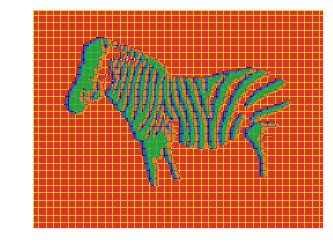

In [12]:
im1 = load_img('img/zebra.jpg')
_,_,H,W = im1.shape

model_list={
    "Feature_Extract":FeatureExtraction,
    "Kmeans":Kmeans
        }
params = {
    "Feature_Extract":{'size':(7,7),
                      'hsv':False},
    "Kmeans":{"k":4,
            "init_method":"k++",
             "im_shape":(H,W),
             "include_coords":True}
            }

model = Pipeline(model_list,params)
model.fit(im1.copy())
model.models["Kmeans"].plot()

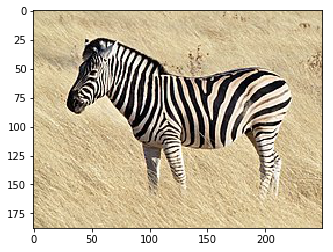

In [13]:
plt.imshow(np.moveaxis(im1[0],0,2))

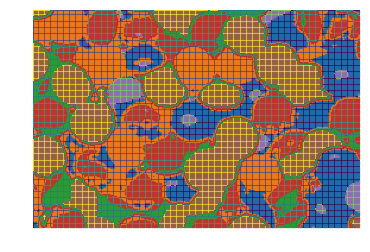

In [14]:
im2 = load_img("img/candies.jpg")
_,_,H,W = im2.shape

model_list={
    "Feature_Extract":FeatureExtraction,
    "Kmeans":Kmeans
        }
params = {
    "Feature_Extract":{'size':(5,5),
                      'hsv':True},
    "Kmeans":{"k":6,
            "init_method":"k++",
             "im_shape":(H,W),
             "include_coords":True}
            }

model = Pipeline(model_list,params)
model.fit(im2.copy())
model.models["Kmeans"].plot()

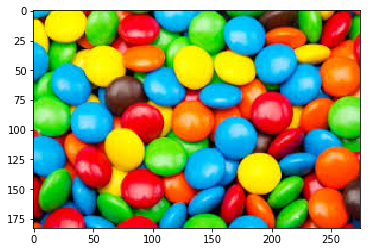

In [15]:
plt.imshow(np.moveaxis(im2[0],0,2))

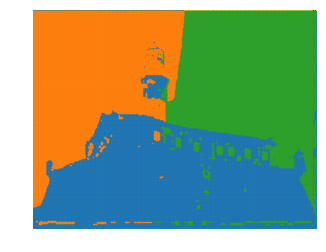

In [16]:
im3 = load_img("img/farol1.jpg")
_,_,H,W = im3.shape

model_list={
    "Feature_Extract":FeatureExtraction,
    "Kmeans":Kmeans
        }
params = {
    "Feature_Extract":{'size':(3,3),
                      'hsv':True},
    "Kmeans":{"k":3,
            "init_method":"k++",
             "im_shape":(H,W),
             "include_coords":True}
            }

model = Pipeline(model_list,params)
model.fit(im3.copy())
model.models["Kmeans"].plot()

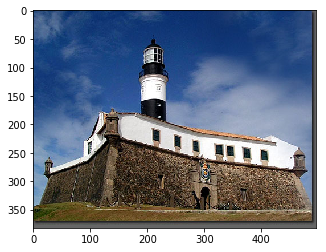

In [17]:
plt.imshow(np.moveaxis(im3[0],0,2))

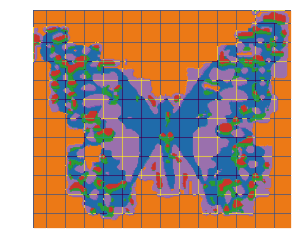

In [18]:
im4 = load_img("img/butterfly.jpg")
_,_,H,W = im4.shape

model_list={
    "Feature_Extract":FeatureExtraction,
    "Kmeans":Kmeans
        }
params = {
    "Feature_Extract":{'size':(5,5),
                      'hsv':True},
    "Kmeans":{"k":5,
            "init_method":"k++",
             "im_shape":(H,W),
             "include_coords":True}
            }

model = Pipeline(model_list,params)
model.fit(im4.copy())
model.models["Kmeans"].plot()

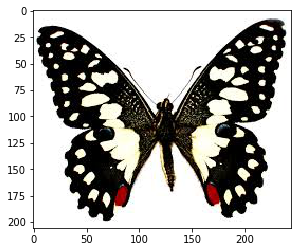

In [19]:
plt.imshow(np.moveaxis(im4[0],0,2))

In [20]:
from visTools_v2.core_functions.operations.reduce_expand import Reduce_stack

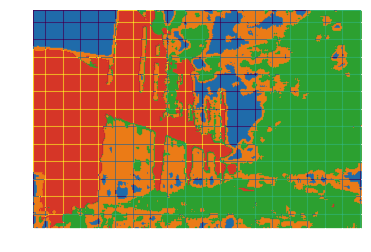

In [21]:
im5 = load_img("img/rotman2.jpg")
im5 = Reduce_stack(im5,4)

_,_,H,W = im5.shape

model_list={
    "Feature_Extract":FeatureExtraction,
    "Kmeans":Kmeans
        }
params = {
    "Feature_Extract":{'size':(5,5),
                      'hsv':True},
    "Kmeans":{"k":4,
            "init_method":"k++",
             "im_shape":(H,W),
             "include_coords":True}
            }

model = Pipeline(model_list,params)
model.fit(im5.copy())
model.models["Kmeans"].plot()


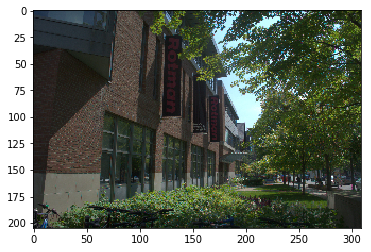

In [22]:
plt.imshow(np.moveaxis(im5[0],0,2))

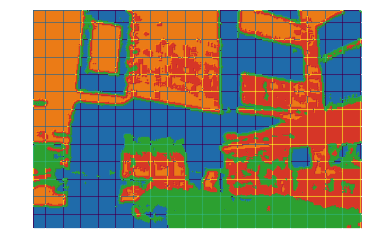

In [23]:
im6 = load_img("img/rotman4.jpg")
im6 = Reduce_stack(im6,4)

_,_,H,W = im6.shape

model_list={
    "Feature_Extract":FeatureExtraction,
    "Kmeans":Kmeans
        }
params = {
    "Feature_Extract":{'size':(5,5),
                      'hsv':True},
    "Kmeans":{"k":4,
            "init_method":"k++",
             "im_shape":(H,W),
             "include_coords":True}
            }

model = Pipeline(model_list,params)
model.fit(im6.copy())
model.models["Kmeans"].plot()


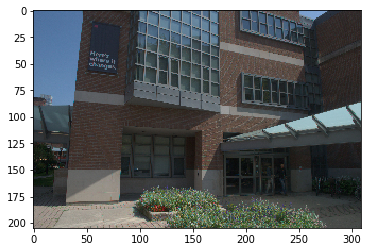

In [24]:
plt.imshow(np.moveaxis(im6[0],0,2))

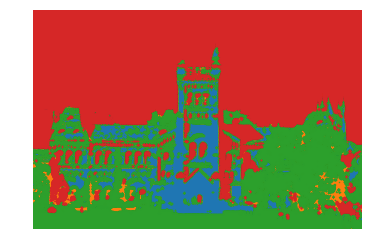

In [25]:
im7 = load_img("img/uoft5.jpg")
im7 = Reduce_stack(im7,2)

_,_,H,W = im7.shape

model_list={
    "Feature_Extract":FeatureExtraction,
    "Kmeans":Kmeans
        }
params = {
    "Feature_Extract":{'size':(5,5),
                      'hsv':True},
    "Kmeans":{"k":4,
            "init_method":"k++",
             "im_shape":(H,W),
             "include_coords":False}
            }

model = Pipeline(model_list,params)
model.fit(im7.copy())
model.models["Kmeans"].plot()


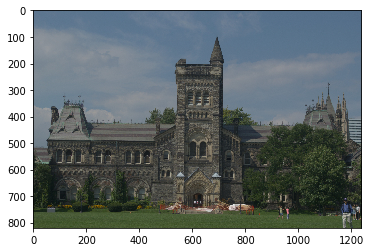

In [26]:
plt.imshow(np.moveaxis(im7[0],0,2))